# Querying the model

This notebook provides an illustration of a workflow for querying the model with a compound of interest, to obtain likely promiscuous enzymes that can function on it. Once model development is at a satisfactory place in terms of performance, this workflow could be used as a framework for building production code for interacting with the model

#### Inputs:
- MASTER_DF.csv
    - Should contain the full database of enzymes included in the model, along with paired compound information for each enzyme
- Query compound
    - Right now this needs to be a PubChem SID number
    
#### Outputs:
- A ranked list of potential promiscuous enzymes and modeled probability values

In [1]:
# imports

from metamoles import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

## Step 1

#### Read in master dataframe

This dataframe has been curated, pre-structured, and stored for use with this workflow.

In [2]:
# read in the master_df

master_df = pd.read_csv('../datasets/MASTER_DF.csv') 
print(master_df.shape)
master_df.head()

(6879, 24)


entry product  reacts  PubChem   SMILES  \
0    1.8.99.5  C00094     1.0     3394  OS(=O)O   
1  1.13.11.18  C00094     1.0     3394  OS(=O)O   
2    1.8.99.5  C00283     1.0     3578        S   
3     2.8.1.2  C00283     1.0     3578        S   
4    4.4.1.28  C00283     1.0     3578        S   

                                              Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x1ac9b8a210>   
1  <rdkit.Chem.rdchem.Mol object at 0x1ac9b8a580>   
2  <rdkit.Chem.rdchem.Mol object at 0x1ac9b8ac10>   
3  <rdkit.Chem.rdchem.Mol object at 0x1ac9b8a2b0>   
4  <rdkit.Chem.rdchem.Mol object at 0x1ac9b8a120>   

                                         Fingerprint      dist  \
0  <rdkit.DataStructs.cDataStructs.ExplicitBitVec...  0.000000   
1  <rdkit.DataStructs.cDataStructs.ExplicitBitVec...  0.511007   
2  <rdkit.DataStructs.cDataStructs.ExplicitBitVec...  0.000000   
3  <rdkit.DataStructs.cDataStructs.ExplicitBitVec...  0.241667   
4  <rdkit.DataStructs.cDataStructs.ExplicitBitVec...  0.294605   

   enzyme_class_1  enzyme_class_2   ...    enzyme_class_7  n_C  n_H  n_O  n_N  \
0               1               0   ...                 0  0.0  2.0  3.0  0.0   
1               1               0   ...                 0  0.0  2.0  3.0  0.0   
2               1               0   ...                 0  0.0  2.0  0.0  0.0   
3               0               1   ...                 0  0.0  2.0  0.0  0.0   
4               0               0   ...                 0  0.0  2.0  0.0  0.0   

   n_P  n_S  n_X  DoU      MW  
0  0.0  1.0  0.0  0.0  82.080  
1  0.0  1.0  0.0  0.0  82.080  
2  0.0  1.0  0.0  0.0  34.083  
3  0.0  1.0  0.0  0.0  34.083  
4  0.0  1.0  0.0  0.0  34.083  

[5 rows x 24 columns]

## Step 2 
#### Get query SMILES string & pair query compound with each unique enzyme in the master DataFrame
Example: PubChem SID 3480

In [3]:
# pair_query_compound_with_enzymes()

updated_df = pair_query_compound(master_df, 'entry', 'PubChem', 'SMILES', '3480')
print(updated_df.shape)
updated_df.head()

(7395, 3)


entry PubChem   SMILES
0    1.8.99.5    3394  OS(=O)O
1  1.13.11.18    3394  OS(=O)O
2    1.8.99.5    3578        S
3     2.8.1.2    3578        S
4    4.4.1.28    3578        S

## Step 3
#### Calculate molecular distances between products of the same enzyme
The model is based on the fact that we expect these distances to be closer for reactive enzyme-product pairs than for non-reactive enzyme-product pairs

In [4]:
# calculate_dist() with appended dataset

distance_df = calculate_dist(updated_df)
print(distance_df.shape)
distance_df.head()

(7395, 6)


entry PubChem   SMILES  \
0    1.8.99.5    3394  OS(=O)O   
1  1.13.11.18    3394  OS(=O)O   
2    1.8.99.5    3578        S   
3     2.8.1.2    3578        S   
4    4.4.1.28    3578        S   

                                              Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x1a1d6d8cb0>   
1  <rdkit.Chem.rdchem.Mol object at 0x1a1d473350>   
2  <rdkit.Chem.rdchem.Mol object at 0x1a1d6d8e40>   
3  <rdkit.Chem.rdchem.Mol object at 0x1a1d8f48f0>   
4  <rdkit.Chem.rdchem.Mol object at 0x1a1d6d8df0>   

                                         Fingerprint      dist  
0  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  0.284869  
1  [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  0.335205  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.284869  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.293565  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.353979

## Step 4
#### Get dummy variables to represent enzyme class
We expect that many enzyme properties could be predictive features for this model. Enzyme class should encapsulate many of these features at a high level.

In [5]:
# remove any rows that are not the query compound

reduced_df = distance_df[distance_df['PubChem'] == '3480']

In [6]:
# binarize_enzyme_class()

query_df = binarize_enzyme_class(reduced_df, 'entry')
query_df = query_df.reset_index(drop=True)
print(query_df.shape)
query_df.head()

(516, 13)


/Users/stephenblaskowski/projects/metamoles/metamoles/metamoles.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe['enzyme_class'] = [row[column][0] for _, row in dataframe.iterrows()]


entry PubChem               SMILES  \
0    1.8.99.5    3480  C1=CC=C(C=C1)C(=O)O   
1  1.13.11.18    3480  C1=CC=C(C=C1)C(=O)O   
2     2.8.1.2    3480  C1=CC=C(C=C1)C(=O)O   
3    4.4.1.28    3480  C1=CC=C(C=C1)C(=O)O   
4    3.13.1.5    3480  C1=CC=C(C=C1)C(=O)O   

                                              Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x1a1de42e40>   
1  <rdkit.Chem.rdchem.Mol object at 0x1a1de42ee0>   
2  <rdkit.Chem.rdchem.Mol object at 0x1a1de42f80>   
3  <rdkit.Chem.rdchem.Mol object at 0x1a1de42e90>   
4  <rdkit.Chem.rdchem.Mol object at 0x1a1de42f30>   

                                         Fingerprint      dist  \
0  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.284869   
1  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.335205   
2  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.293565   
3  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.353979   
4  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.301190   

   enzyme_class_1  enzyme_class_2  enzyme_class_3  enzyme_class_4  \
0               1               0               0               0   
1               1               0               0               0   
2               0               1               0               0   
3               0               0               0               1   
4               0               0               1               0   

   enzyme_class_5  enzyme_class_6  enzyme_class_7  
0               0               0               0  
1               0               0               0  
2               0               0               0  
3               0               0               0  
4               0               0               0

## Step 5
#### Add in compound features with RDKit
This step uses the RDKit packages to generate descriptive features of the reaction product compounds

In [7]:
query_df = create_cpd_info(query_df)
print(query_df.shape)
query_df.head()

(516, 22)


entry PubChem               SMILES  \
0    1.8.99.5    3480  C1=CC=C(C=C1)C(=O)O   
1  1.13.11.18    3480  C1=CC=C(C=C1)C(=O)O   
2     2.8.1.2    3480  C1=CC=C(C=C1)C(=O)O   
3    4.4.1.28    3480  C1=CC=C(C=C1)C(=O)O   
4    3.13.1.5    3480  C1=CC=C(C=C1)C(=O)O   

                                              Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x1a1de42e40>   
1  <rdkit.Chem.rdchem.Mol object at 0x1a1de42ee0>   
2  <rdkit.Chem.rdchem.Mol object at 0x1a1de42f80>   
3  <rdkit.Chem.rdchem.Mol object at 0x1a1de42e90>   
4  <rdkit.Chem.rdchem.Mol object at 0x1a1de42f30>   

                                         Fingerprint      dist  \
0  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.284869   
1  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.335205   
2  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.293565   
3  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.353979   
4  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.301190   

   enzyme_class_1  enzyme_class_2  enzyme_class_3  enzyme_class_4   ...     \
0               1               0               0               0   ...      
1               1               0               0               0   ...      
2               0               1               0               0   ...      
3               0               0               0               1   ...      
4               0               0               1               0   ...      

   enzyme_class_7  n_C  n_H  n_O  n_N  n_P  n_S  n_X  DoU       MW  
0               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
1               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
2               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
3               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  
4               0  7.0  6.0  2.0  0.0  0.0  0.0  0.0  5.0  122.123  

[5 rows x 22 columns]

## Step 6
#### Re-Instantiate model

In [8]:
# create new dataframe with desired features for training model
# current version of the model uses the following features
feature_df = master_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
       'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
       'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]

# shape array for regression
features = np.array(feature_df) 
reactions = list(master_df['reacts'])

feature_train, feature_test, reaction_train, reaction_test = train_test_split(features, reactions,
                                                  test_size=0.20, random_state=42)

model_1 = linear_model.LogisticRegression(solver='liblinear', penalty='l1', random_state=1, class_weight='balanced')
model_1.fit(feature_train, np.ravel(reaction_train))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=1,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

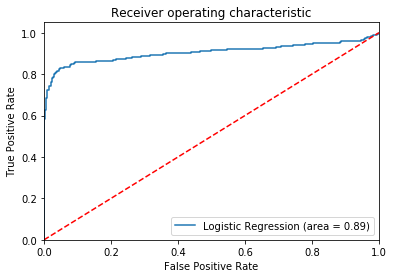

The model score is 91.93%.


In [9]:
# Test the model

logit_roc_auc = roc_auc_score(reaction_test, model_1.predict(feature_test))

fpr, tpr, thresholds = roc_curve(reaction_test, model_1.predict_proba(feature_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

score = model_1.score(feature_test, reaction_test)
print('The model score is ' + str(round(score*100, 2)) + '%.')

## Step 7 
#### Use model to predict reactivity of pairs

In [10]:
# select query features
# must match features for model training

query_feat_df = query_df[['dist', 'enzyme_class_1', 'enzyme_class_2', 'enzyme_class_3',
       'enzyme_class_4', 'enzyme_class_5', 'enzyme_class_6', 'enzyme_class_7',
       'n_O', 'n_N', 'n_S', 'n_X', 'DoU']]

In [11]:
# query the model

predictions = model_1.predict(query_feat_df) 

pred = model_1.predict_proba(query_feat_df)

prediction_values = pd.DataFrame(pred)
model_descriptive_df = pd.DataFrame()
model_descriptive_df['0']=prediction_values[0]
model_descriptive_df['1']=prediction_values[1]

In [12]:
# create a dataframe of model predictions

prediction_df = pd.merge(model_descriptive_df, query_df, left_index=True, right_index=True) 
print(prediction_df.shape)
prediction_df.head()

(516, 24)


0         1       entry PubChem               SMILES  \
0  0.951846  0.048154    1.8.99.5    3480  C1=CC=C(C=C1)C(=O)O   
1  0.879409  0.120591  1.13.11.18    3480  C1=CC=C(C=C1)C(=O)O   
2  0.948483  0.051517     2.8.1.2    3480  C1=CC=C(C=C1)C(=O)O   
3  0.656471  0.343529    4.4.1.28    3480  C1=CC=C(C=C1)C(=O)O   
4  0.951822  0.048178    3.13.1.5    3480  C1=CC=C(C=C1)C(=O)O   

                                              Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x1a1de42e40>   
1  <rdkit.Chem.rdchem.Mol object at 0x1a1de42ee0>   
2  <rdkit.Chem.rdchem.Mol object at 0x1a1de42f80>   
3  <rdkit.Chem.rdchem.Mol object at 0x1a1de42e90>   
4  <rdkit.Chem.rdchem.Mol object at 0x1a1de42f30>   

                                         Fingerprint      dist  \
0  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.284869   
1  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.335205   
2  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.293565   
3  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.353979   
4  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.301190   

   enzyme_class_1  enzyme_class_2   ...     enzyme_class_7  n_C  n_H  n_O  \
0               1               0   ...                  0  7.0  6.0  2.0   
1               1               0   ...                  0  7.0  6.0  2.0   
2               0               1   ...                  0  7.0  6.0  2.0   
3               0               0   ...                  0  7.0  6.0  2.0   
4               0               0   ...                  0  7.0  6.0  2.0   

   n_N  n_P  n_S  n_X  DoU       MW  
0  0.0  0.0  0.0  0.0  5.0  122.123  
1  0.0  0.0  0.0  0.0  5.0  122.123  
2  0.0  0.0  0.0  0.0  5.0  122.123  
3  0.0  0.0  0.0  0.0  5.0  122.123  
4  0.0  0.0  0.0  0.0  5.0  122.123  

[5 rows x 24 columns]

In [13]:
# sort the data so "Yes, it will react" predictions are at the top

prediction_df = prediction_df.sort_values(by=['1'], ascending=False)
prediction_df.head()

0         1       entry PubChem               SMILES  \
359  0.201624  0.798376   1.1.1.187    3480  C1=CC=C(C=C1)C(=O)O   
365  0.249770  0.750230   1.3.1.115    3480  C1=CC=C(C=C1)C(=O)O   
319  0.250410  0.749590  1.14.14.50    3480  C1=CC=C(C=C1)C(=O)O   
174  0.251504  0.748496    4.1.1.96    3480  C1=CC=C(C=C1)C(=O)O   
254  0.265173  0.734827   4.2.1.165    3480  C1=CC=C(C=C1)C(=O)O   

                                                Mol  \
359  <rdkit.Chem.rdchem.Mol object at 0x1a1de51440>   
365  <rdkit.Chem.rdchem.Mol object at 0x1a1de51800>   
319  <rdkit.Chem.rdchem.Mol object at 0x1a1de4fa80>   
174  <rdkit.Chem.rdchem.Mol object at 0x1a1de49da0>   
254  <rdkit.Chem.rdchem.Mol object at 0x1a1de4cf30>   

                                           Fingerprint      dist  \
359  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.504968   
365  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.491018   
319  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.490846   
174  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.441723   
254  [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...  0.438121   

     enzyme_class_1  enzyme_class_2   ...     enzyme_class_7  n_C  n_H  n_O  \
359               1               0   ...                  0  7.0  6.0  2.0   
365               1               0   ...                  0  7.0  6.0  2.0   
319               1               0   ...                  0  7.0  6.0  2.0   
174               0               0   ...                  0  7.0  6.0  2.0   
254               0               0   ...                  0  7.0  6.0  2.0   

     n_N  n_P  n_S  n_X  DoU       MW  
359  0.0  0.0  0.0  0.0  5.0  122.123  
365  0.0  0.0  0.0  0.0  5.0  122.123  
319  0.0  0.0  0.0  0.0  5.0  122.123  
174  0.0  0.0  0.0  0.0  5.0  122.123  
254  0.0  0.0  0.0  0.0  5.0  122.123  

[5 rows x 24 columns]

## Full Model Validation

The bit of code below is used to test the model on all of the validation compounds. It runs each of the compounds set aside prior to model training through the model query workflow outlined above, and outputs the results to a csv for further analysis.

In [16]:
# read in validation data

validation_df = pd.read_csv('../datasets/validation_data/validation_data.csv')
# read in smiles string data
smiles_df = pd.read_csv('../datasets/PubChem_compounds_SMILES.csv', dtype='str')
# join on validation_df to get sid numbers
valid_df = pd.merge(validation_df, smiles_df, left_on='product', right_on='KEGG', how='left')
valid_df = valid_df.drop(columns=['Unnamed: 0_x', 'product', 'Unnamed: 0_y', 'entry_y', 'CID', 'SMILES'])
valid_df = valid_df.rename(columns={'entry_x': 'true_enzyme'})
valid_df = valid_df.drop_duplicates()
valid_df = valid_df.dropna(subset=['PubChem'])
valid_df = valid_df.reset_index(drop=True)
print(valid_df.shape)
valid_df.head()

(207, 3)


true_enzyme    KEGG    PubChem
0   2.4.1.330  C19867  135626334
1    4.3.1.17  C20904  254741367
2   1.2.99.10  C21766  354339113
3  1.13.11.16  C12624     583014
4   2.1.1.324  C18033   96024253

In [ ]:
# run each of these validation compounds through the query_model() function
# WARNING: this takes a very long time to run as is

headers = ['true_enzyme', 'KEGG', 'PubChem', 'prediction_rank', 'prediction_prob']
valid_pred_df = valid_df.reindex(columns=headers)

cpd_validation_list = valid_pred_df['PubChem'].unique().tolist()
# cpd_validation_list = ['135626334', '254741367']

for cpd in cpd_validation_list:
    try:
        prediction_df = query_model(master_df, cpd)
    except:
        pass
    handle = '../datasets/validation_data/{}.csv'.format(cpd)
    prediction_df.to_csv(handle, index=False)
    for index, row in valid_pred_df.loc[valid_pred_df.loc[:, 'PubChem'] == cpd].iterrows():
        enzyme = row['true_enzyme']
        for _, pred_row in prediction_df.loc[prediction_df.loc[:,'entry'] == enzyme].iterrows():
            valid_pred_df.loc[index, 'prediction_rank'] = pred_row['rank']
            valid_pred_df.loc[index, 'prediction_prob'] = pred_row['p_reacts']
    valid_pred_df.to_csv('validation_summary.csv', index=False)

valid_pred_df.head()

In [ ]:
valid_pred_df.head()